In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

import pickle

from tqdm import tqdm
import os
import sys

In [452]:
with open ('C:\\Users\\matth\Programming\\Assignments\\ICT3909\\ablation\\images\\names.txt', 'r') as f:
    names = f.readlines()
    names = [name.strip() for name in names]

<>:1: SyntaxWarning: invalid escape sequence '\P'
<>:1: SyntaxWarning: invalid escape sequence '\P'
C:\Users\matth\AppData\Local\Temp\ipykernel_19544\1564091847.py:1: SyntaxWarning: invalid escape sequence '\P'
  with open ('C:\\Users\\matth\Programming\\Assignments\\ICT3909\\ablation\\images\\names.txt', 'r') as f:


In [101]:
a_path = '../gazedataset/GazePoint/GROUP A/result/CSV/'
b_path = '../gazedataset/GazePoint/GROUP B/result/CSV/'
interface_path = '../gazedataset/Interfaces/'

In [102]:
# List of all files containing "fixations"
a_files = [f for f in os.listdir(a_path) if "fixations" in f]
b_files = [f for f in os.listdir(b_path) if "fixations" in f]

# a_files = [f for f in os.listdir(a_path) if "all_gaze" in f]
# b_files = [f for f in os.listdir(b_path) if "all_gaze" in f]

img_paths = [f for f in os.listdir(interface_path) if (".png" in f)]

In [103]:
conv = {
    'DESKTOP_A': 'DESKTOP_B',
    'ILLUM_14_03_24_A': 'ILLUM_14_03_24_B',
    'INDEPENDENT_14_03_24_A': 'INDEPENDENT_14_03_24_B',
    'LOVIN_MALTA_04_03_24_A': 'LOVIN_MALTA_04_03_24_B',
    'MALTA_TODAY_14_03_24_A': 'MALTA_TODAY_14_03_24_B',
    'MOBILE_A': 'MOBILE_B',
    'THE_SHIFT_14_03_24_A': 'THE_SHIFT_14_03_24_B',
    'TIMES_OF_MALTA_15_03_24_A': 'TIMES_OF_MALTA_15_03_24_B',
    'TIMES_OF_MALTA_29_02_24_A': 'TIMES_OF_MALTA_26_02_24_B',
    'TVM_14_03_24_A': 'TVM_14_03_24_B',
}

conv_jpg = {
    'DESKTOP_A': 'DESKTOP_B',
    'ILLUM_14_03_24_A': 'ILLUM_14_03_24_B',
    'INDEPENDENT_14_03_24_A': 'INDEPENDENT_14_03_24_B',
    'LOVIN_MALTA_04_03_24_A': 'LOVIN_MALTA_04_03_24_B',
    'MALTA_TODAY_14_03_24_A': 'MALTA_TODAY_14_03_24_B',
    'MOBILE_A': 'MOBILE_B',
    'THE_SHIFT_14_03_24_A': 'THE_SHIFT_14_03_24_B',
    'TIMES_OF_MALTA_15_03_24_A': 'TIMES_OF_MALTA_15_03_24_B',
    'TIMES_OF_MALTA_29_02_24_A': 'TIMES_OF_MALTA_26_02_24_B',
    'TVM_14_03_24_A': 'TVM_14_03_24_B',
}

# Append png to all keys and values in conv
original = conv.copy()
conv = {k + '.png': v + '.png' for k, v in original.items()}
conv_jpg = {k + '.jpg': v + '.png' for k, v in original.items()}
conv_a = {k + '.jpg': k + '.png' for k, v in original.items()}

In [118]:
# 30 random colours
colours = np.random.randint(0, 255, (30, 3))

In [105]:
a_df = pd.DataFrame()
b_df = pd.DataFrame()

for i, f in enumerate(a_files):
    # Read the csv file
    csv = pd.read_csv(a_path + f)
    # Rename the 4th column to TIME
    csv = csv.rename(columns={csv.columns[3]: 'TIME'})

    # Add a column with participant ID, start from 0, use i
    csv = csv.assign(PARTICIPANT=i)

    a_df = pd.concat([a_df, csv])

for j, f in enumerate(b_files):
    j += i + 1
    # Read the csv file
    csv = pd.read_csv(b_path + f)
    # Rename the 4th column to TIME
    csv = csv.rename(columns={csv.columns[3]: 'TIME'})
    
    csv = csv.assign(PARTICIPANT=j)

    b_df = pd.concat([b_df, csv])

In [106]:
# Convert all instances of keys in conv to values in b_df
b_df['MEDIA_NAME'] = b_df['MEDIA_NAME'].replace(conv)
b_df['MEDIA_NAME'] = b_df['MEDIA_NAME'].replace(conv_jpg)
a_df['MEDIA_NAME'] = a_df['MEDIA_NAME'].replace(conv_a)

In [7]:
# # Find the min and max values of FPOGX and FPOGY. Scale the values to 0-1
# a_min_x = a_df['FPOGX'].min()
# a_max_x = a_df['FPOGX'].max()

# a_min_y = a_df['FPOGY'].min()
# a_max_y = a_df['FPOGY'].max()

# b_min_x = b_df['FPOGX'].min()
# b_max_x = b_df['FPOGX'].max()

# b_min_y = b_df['FPOGY'].min()
# b_max_y = b_df['FPOGY'].max()


# a_df['FPOGX'] = (a_df['FPOGX'] - a_min_x) / (a_max_x - a_min_x)
# a_df['FPOGY'] = (a_df['FPOGY'] - a_min_y) / (a_max_y - a_min_y)

# b_df['FPOGX'] = (b_df['FPOGX'] - b_min_x) / (b_max_x - b_min_x)
# b_df['FPOGY'] = (b_df['FPOGY'] - b_min_y) / (b_max_y - b_min_y)

In [107]:
imgs = {}

for img_path in img_paths:
    img = cv2.imread(interface_path + img_path)
    imgs[img_path.split('/')[-1]] = img


In [165]:
def add_circle_to_heatmap(heatmap, x, y, radius, intensity=1, colour=None):
    y_min, y_max = max(0, int(y - radius)), min(heatmap.shape[0], int(y + radius))
    x_min, x_max = max(0, int(x - radius)), min(heatmap.shape[1], int(x + radius))

    for i in range(y_min, y_max):
        for j in range(x_min, x_max):
            distance = np.sqrt((i - y)**2 + (j - x)**2)
            if distance <= radius:
                if colour is None:
                    heatmap[i, j] += intensity
                else:
                    heatmap[i, j] = colour

In [109]:
a_df.columns[3]

'TIME'

In [110]:
row

MEDIA_ID                                            8
MEDIA_NAME              TIMES_OF_MALTA_29_02_24_A.jpg
CNT                                                19
TIME                                          0.31226
TIMETICK(f=10000000)                      32795818837
FPOGX                                         0.61071
FPOGY                                         0.10406
FPOGS                                             0.0
FPOGD                                         0.31225
FPOGID                                              1
FPOGV                                               1
BPOGX                                         0.59495
BPOGY                                          0.1304
BPOGV                                               1
CX                                            1.34219
CY                                            0.33426
CS                                                  0
USER                                              NaN
LPCX                        

In [197]:
del x
del y

In [297]:
# Initialize the heatmaps dictionary
heatmaps = {}

r = 5
xs = []
factor = 1920 / 1080
# Initialize heatmaps for each image
for img_path in img_paths:
    # heatmaps[img_path] = np.zeros((imgs[img_path].shape[0], imgs[img_path].shape[1]))
    heatmaps[img_path] = np.zeros((1080, 1920, 4))

# Add circles from a_df with a progress bar
for i, row in tqdm(a_df.iterrows(), total=a_df.shape[0], desc='Processing a_df'):
    img_path = row['MEDIA_NAME']
    intensity = row['FPOGD']
    # Check which columns contains "TIME" in it
    time = row[a_df.columns[3]]
    pid = row['PARTICIPANT']
    colour = colours[pid]
    time = time + 0.001
    colour = [int(c) for c in colour] + [255 // time]


    if row['FPOGX'] < 0 or row['FPOGY'] < 0 or row['FPOGX'] > 1 or row['FPOGY'] > 1:
        continue
    
    try:
        last = (x, y)
    except:
        continue
    finally:
    
        x = np.floor(row['FPOGX'] * np.zeros((1080, 1920)).shape[1]).astype(int)
        y = np.floor(row['FPOGY'] * np.zeros((1080, 1920)).shape[0]).astype(int)

        new = (x, y)

        # Draw a line from last to new
        cv2.line(heatmaps[img_path], last, new, colour, 2)

        add_circle_to_heatmap(heatmaps[img_path], x, y, intensity * 30, time, colour=colour)
        # heatmaps[img_path][y, x] += 1

# Add circles from b_df with a progress bar
for i, row in tqdm(b_df.iterrows(), total=b_df.shape[0], desc='Processing b_df'):
    img_path = row['MEDIA_NAME']
    intensity = row['FPOGD']
    time = row[a_df.columns[3]]
    pid = row['PARTICIPANT']
    colour = colours[pid]
    colour = [int(c) for c in colour] + [255]

    if row['FPOGX'] < 0 or row['FPOGY'] < 0 or row['FPOGX'] > 1 or row['FPOGY'] > 1:
        continue

    
    try:
        last = (x, y)
    except:
        continue
    finally:

        x = np.floor(row['FPOGX'] * np.zeros((1080, 1920)).shape[1]).astype(int)
        y = np.floor(row['FPOGY'] * np.zeros((1080, 1920)).shape[0]).astype(int)

        new = (x, y)
        
        # Draw a line from last to new
        cv2.line(heatmaps[img_path], last, new, colour, 2)
        
        add_circle_to_heatmap(heatmaps[img_path], x, y, intensity * 30, time, colour=colour)
        # heatmaps[img_path][y, x] += 1

for img_path in img_paths:
    # Crop portait heatmaps, they are currently 1920x1080, must be 1080x1920 
    if imgs[img_path].shape[0] > imgs[img_path].shape[1]:
        heatmaps[img_path] = heatmaps[img_path][:, 420:1500]
        # Scale to 1080x1920
        heatmaps[img_path] = cv2.resize(heatmaps[img_path], (1920, 1920))
        heatmaps[img_path] = heatmaps[img_path][:, 420:1500]

# Save heatmaps to pickle
with open('heatmaps_time.pkl', 'wb') as f:
    pickle.dump(heatmaps, f)

Processing b_df: 100%|██████████| 3188/3188 [00:03<00:00, 833.68it/s]


In [364]:
# 30 random colours
colours = np.random.randint(0, 255, (30, 3))

In [403]:
totals = {}
# Initialize the heatmaps dictionary
heatmaps = {}

r = 5
xs = []
factor = 1920 / 1080
# Initialize heatmaps for each image
for img_path in img_paths:
    # heatmaps[img_path] = np.zeros((imgs[img_path].shape[0], imgs[img_path].shape[1]))
    heatmaps[img_path] = {}

# Add circles from a_df with a progress bar
for i, row in tqdm(a_df.iterrows(), total=a_df.shape[0], desc='Processing a_df'):
    img_path = row['MEDIA_NAME']
    if img_path not in totals:
        totals[img_path] = {}

    intensity = row['FPOGD']
    # Check which columns contains "TIME" in it
    time = row[a_df.columns[3]]
    pid = row['PARTICIPANT']
    colour = colours[pid]
    time = time + 0.001
    colour = [int(c) for c in colour] + [255 // time]


    if row['FPOGX'] < 0 or row['FPOGY'] < 0 or row['FPOGX'] > 1 or row['FPOGY'] > 1:
        continue

    x = np.floor(row['FPOGX'] * np.zeros((1080, 1920)).shape[1]).astype(int)
    y = np.floor(row['FPOGY'] * np.zeros((1080, 1920)).shape[0]).astype(int)

    

    # Round time to nearest second
    time = np.round(time)

    # If the time is not in the averages dictionary, add it
    if time not in totals[img_path]:
        totals[img_path][time] = []
        heatmaps[img_path][time] = np.zeros((1080, 1920))

    totals[img_path][time] += [[x, y]]
    heatmaps[img_path][time][y, x] += 1

# Add circles from b_df with a progress bar
for i, row in tqdm(b_df.iterrows(), total=b_df.shape[0], desc='Processing b_df'):
    img_path = row['MEDIA_NAME']
    if img_path not in totals:
        totals[img_path] = {}

    intensity = row['FPOGD']
    # Check which columns contains "TIME" in it
    time = row[b_df.columns[3]]
    pid = row['PARTICIPANT']
    colour = colours[pid]
    time = time + 0.001
    colour = [int(c) for c in colour] + [255 // time]

    if row['FPOGX'] < 0 or row['FPOGY'] < 0 or row['FPOGX'] > 1 or row['FPOGY'] > 1:
        continue

    x = np.floor(row['FPOGX'] * np.zeros((1080, 1920)).shape[1]).astype(int)
    y = np.floor(row['FPOGY'] * np.zeros((1080, 1920)).shape[0]).astype(int)

    

    # Round time to nearest second
    time = np.round(time)

    # If the time is not in the averages dictionary, add it
    if time not in totals[img_path]:
        totals[img_path][time] = []
        heatmaps[img_path][time] = np.zeros((1080, 1920))

    totals[img_path][time] += [[x, y]]
    heatmaps[img_path][time][y, x] += 1

for img_path in img_paths:
    for time in heatmaps[img_path]:
        # Crop portait heatmaps, they are currently 1920x1080, must be 1080x1920 
        if imgs[img_path].shape[0] > imgs[img_path].shape[1]:
            heatmaps[img_path][time] = heatmaps[img_path][time][:, 420:1500]
            # Scale to 1080x1920
            heatmaps[img_path][time] = cv2.resize(heatmaps[img_path][time], (1920, 1920))
            heatmaps[img_path][time] = heatmaps[img_path][time][:, 420:1500]

# # Save heatmaps to pickle
# with open('heatmaps_time.pkl', 'wb') as f:
#     pickle.dump(heatmaps, f)

Processing b_df: 100%|██████████| 3188/3188 [00:00<00:00, 6444.84it/s]


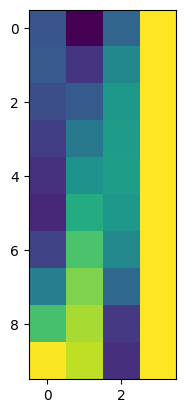

In [269]:
plt.imshow(colours)

dict_keys(['DESKTOP_A.png', 'DESKTOP_B.png', 'ILLUM_14_03_24_A.png', 'ILLUM_14_03_24_B.png', 'INDEPENDENT_14_03_24_A.png', 'INDEPENDENT_14_03_24_B.png', 'LOVIN_MALTA_04_03_24_A.png', 'LOVIN_MALTA_04_03_24_B.png', 'MALTA_TODAY_14_03_24_A.png', 'MALTA_TODAY_14_03_24_B.png', 'MOBILE_A.png', 'MOBILE_B.png', 'THE_SHIFT_14_03_24_A.png', 'THE_SHIFT_14_03_24_B.png', 'TIMES_OF_MALTA_15_03_24_A.png', 'TIMES_OF_MALTA_15_03_24_B.png', 'TIMES_OF_MALTA_26_02_24_B.png', 'TIMES_OF_MALTA_29_02_24_A.png', 'TVM_14_03_24_A.png', 'TVM_14_03_24_B.png'])

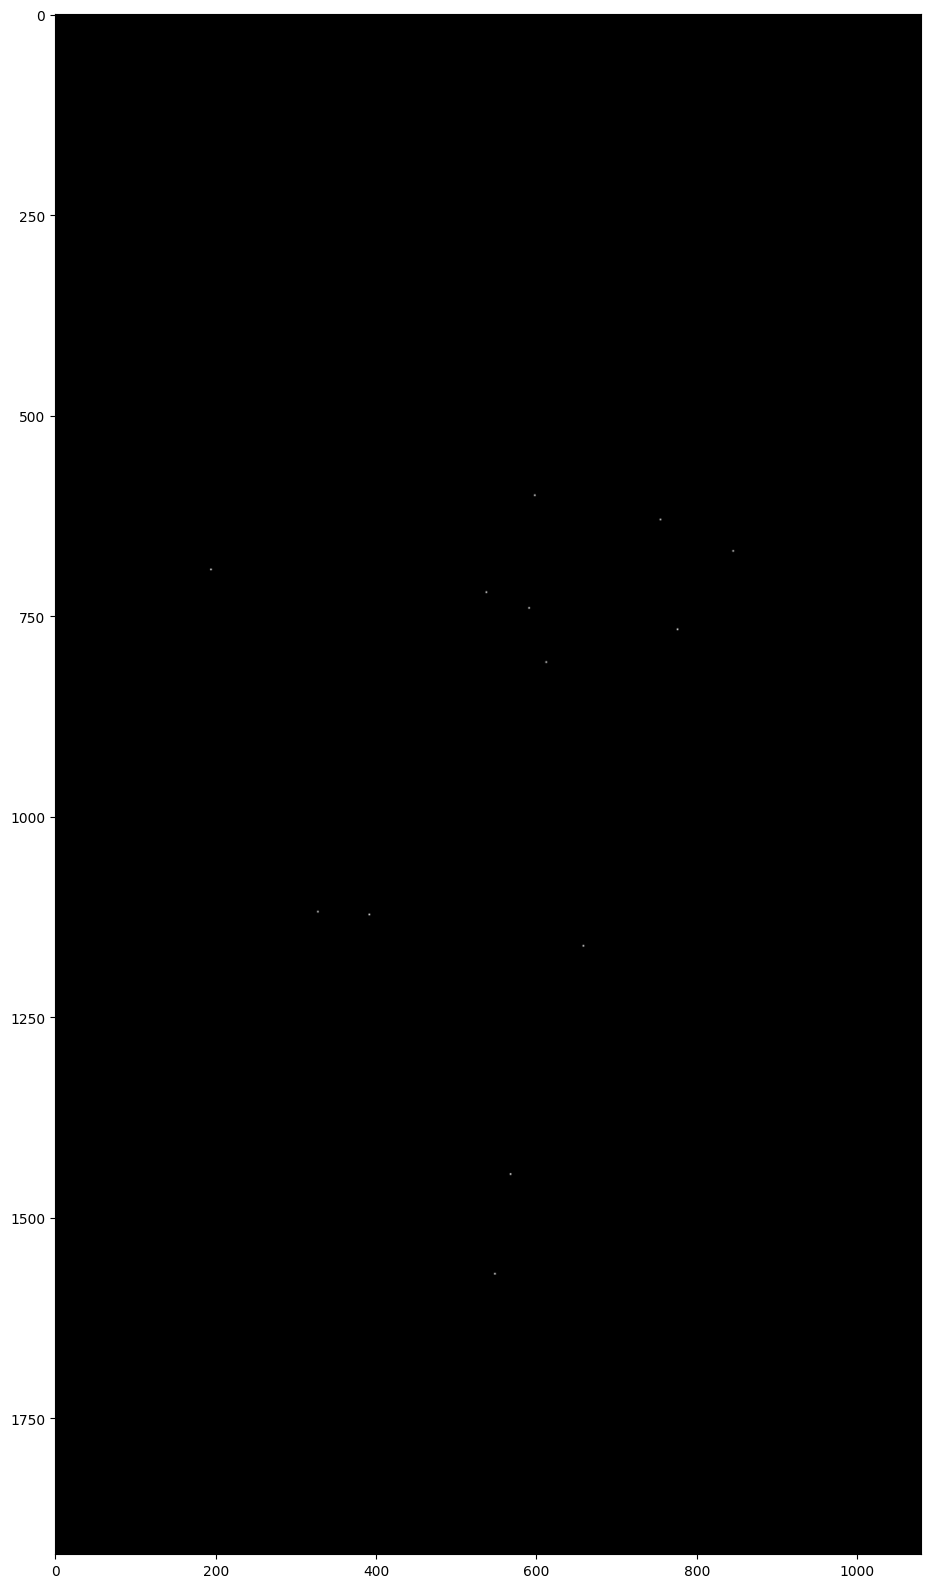

In [419]:
plt.figure(figsize=(20, 20))
plt.imshow(heatmaps[img_paths[3]][0], cmap='gray')

In [398]:
# Count of all non-zero rows and columns in heatmaps

In [397]:
plt.figure(figsize=(10, 10))
# plt.imshow(heatmaps[img_paths[0]], cmap='gray')

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [ ]:

for img_path in img_paths:
    # Crop portait heatmaps, they are currently 1920x1080, must be 1080x1920 
    if imgs[img_path].shape[0] > imgs[img_path].shape[1]:
        heatmaps[img_path] = heatmaps[img_path][:, 420:1500]
        # Scale to 1080x1920
        heatmaps[img_path] = cv2.resize(heatmaps[img_path], (1920, 1920))
        heatmaps[img_path] = heatmaps[img_path][:, 420:1500]

In [434]:
np.unravel_index(time_heatmap.argmax(), time_heatmap.shape)

(80, 490)

In [441]:
do_average = False

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


../evaluation/Figures/Illum/ILLUM_14_03_24_A_MOUSE_VIRIDIS.png


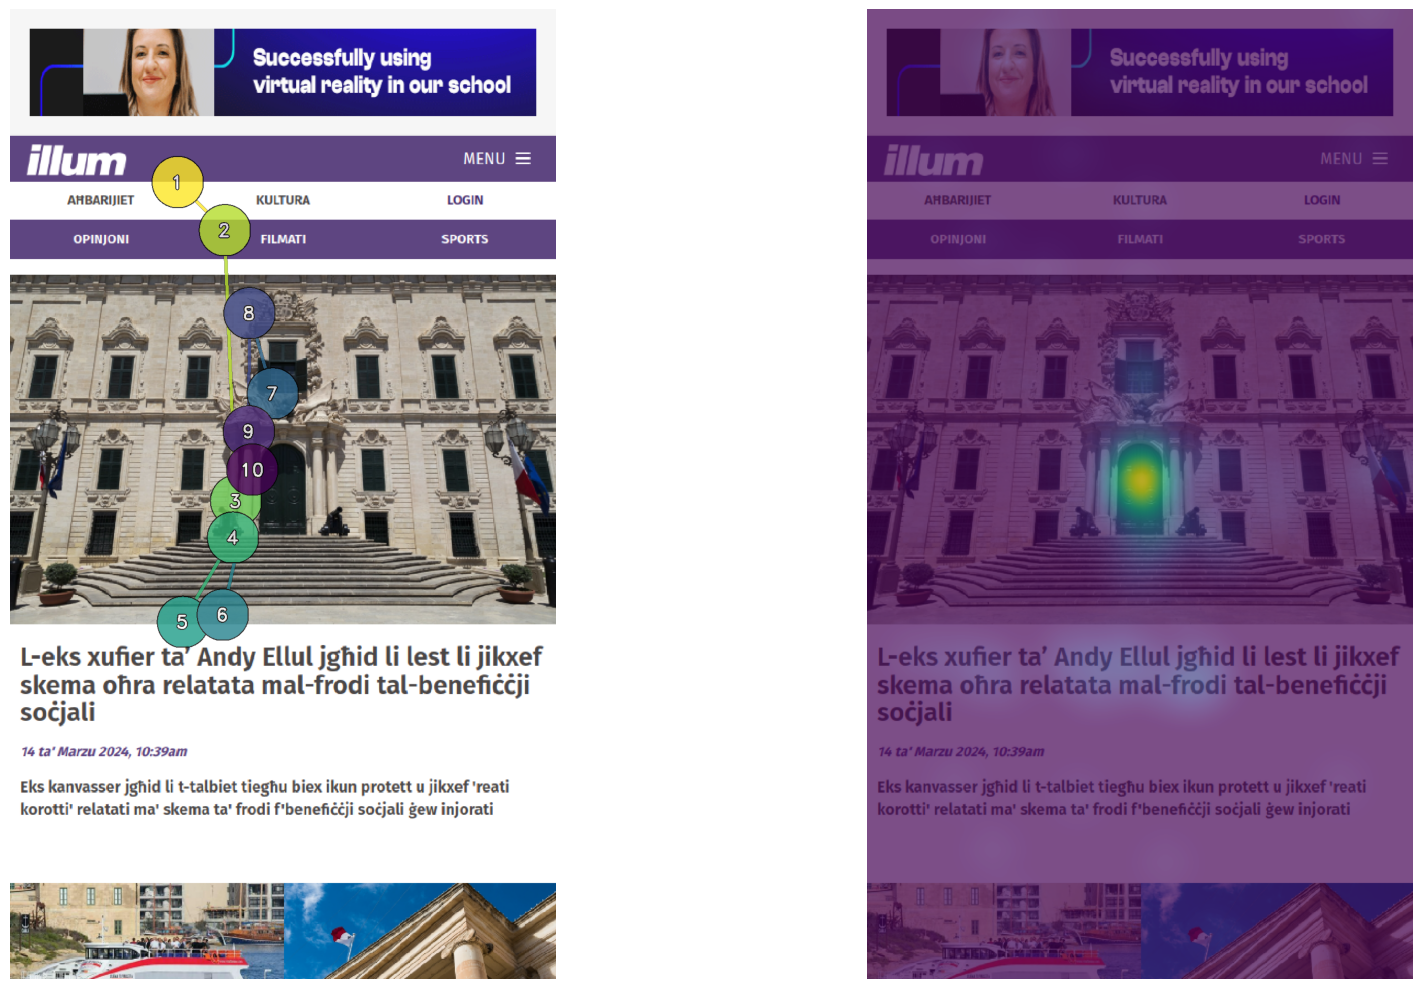

In [536]:
from PIL import ImageFont, ImageDraw, Image

n = 2
r = 50

heatmap = np.zeros((imgs[img_paths[n]].shape[:2][0], imgs[img_paths[n]].shape[:2][1], 4))

last = None

# Get 10 colours from the viridis colormap
colours = plt.cm.viridis(np.linspace(0, 1, 10))
colours = list(reversed(colours))
# Set alpha to 200 for all
for (second, total) in sorted(totals[img_paths[n]].items())[1:]:
    second = int(second)

    # Get x_avg and y_avg from heatmaps
    time_heatmap = heatmaps[img_paths[n]][second]

    height, width = time_heatmap.shape
    x_coords, y_coords = np.meshgrid(np.arange(width), np.arange(height))
    x_coords_flat = x_coords.flatten()
    y_coords_flat = y_coords.flatten()
    heatmap_flat = time_heatmap.flatten()
    x_avg = np.average(x_coords_flat, weights=heatmap_flat)
    y_avg = np.average(y_coords_flat, weights=heatmap_flat)


    # x_avg = np.average([x for x, y in total])
    # y_avg = np.average([y for x, y in total])

    if last:
        cv2.line(heatmap, [int(last[0]), int(last[1])], (int(x_avg), int(y_avg)), colours[second - 2], 5)

    # add_circle_to_heatmap(heatmap, x_avg, y_avg, 35, 1, colour=colours[second - 1])
    # # Add text to the heatmap
    # cv2.putText(heatmap, str(int(second)), (int(x_avg) - 5, int(y_avg) + 5), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255, 255), 2, cv2.LINE_AA)

    last = (x_avg, y_avg)

for (second, total) in sorted(totals[img_paths[n]].items())[1:]:
    second = int(second)

    # Get x_avg and y_avg from heatmaps
    time_heatmap = heatmaps[img_paths[n]][second]

    height, width = time_heatmap.shape
    x_coords, y_coords = np.meshgrid(np.arange(width), np.arange(height))
    x_coords_flat = x_coords.flatten()
    y_coords_flat = y_coords.flatten()
    heatmap_flat = time_heatmap.flatten()
    x_avg = np.average(x_coords_flat, weights=heatmap_flat)
    y_avg = np.average(y_coords_flat, weights=heatmap_flat)
    # x_avg = np.average([x for x, y in total])
    # y_avg = np.average([y for x, y in total])

    # if last:
    #     cv2.line(heatmap, [int(last[0]), int(last[1])], (int(x_avg), int(y_avg)), colours[second - 1], 2)

    add_circle_to_heatmap(heatmap, x_avg, y_avg, r+2, 1, colour=[0, 0, 0, 255])
    add_circle_to_heatmap(heatmap, x_avg, y_avg, r, 1, colour=colours[second - 1])


    text = str(int(second))
    font_scale = 1
    font = cv2.FONT_HERSHEY_SIMPLEX
    thickness = 2
    text_size = cv2.getTextSize(text, font, font_scale, thickness)[0]

    text_x = int(x_avg - text_size[0] / 2)
    text_y = int(y_avg + text_size[1] / 2)

    # # Add text to the heatmap
    # cv2.putText(heatmap, text, (text_x, text_y), font, font_scale, (255, 255, 255, 255), thickness, cv2.LINE_AA)

    last = (x_avg, y_avg)

for (second, total) in sorted(totals[img_paths[n]].items())[1:]:
    second = int(second)

    # Get x_avg and y_avg from heatmaps
    time_heatmap = heatmaps[img_paths[n]][second]

    height, width = time_heatmap.shape
    x_coords, y_coords = np.meshgrid(np.arange(width), np.arange(height))
    x_coords_flat = x_coords.flatten()
    y_coords_flat = y_coords.flatten()
    heatmap_flat = time_heatmap.flatten()
    x_avg = np.average(x_coords_flat, weights=heatmap_flat)
    y_avg = np.average(y_coords_flat, weights=heatmap_flat)

    # x_avg = np.average([x for x, y in total])
    # y_avg = np.average([y for x, y in total])

    # if last:
    #     cv2.line(heatmap, [int(last[0]), int(last[1])], (int(x_avg), int(y_avg)), colours[second - 1], 2)

    # add_circle_to_heatmap(heatmap, x_avg, y_avg, 50, 1, colour=colours[second - 1])


    text = str(int(second))
    font_scale = 1.2
    font = cv2.FONT_HERSHEY_DUPLEX
    thickness = 2
    text_size = cv2.getTextSize(text, font, font_scale, thickness)[0]

    text_x = int(x_avg - text_size[0] / 2)
    text_y = int(y_avg + text_size[1] / 2)

    # Add text to the heatmap
    cv2.putText(heatmap, text, (text_x, text_y), font, font_scale, (0, 0, 0, 25), thickness + 4, cv2.LINE_AA)
    cv2.putText(heatmap, text, (text_x, text_y), font, font_scale, (255, 255, 255, 255), thickness, cv2.LINE_AA)

    last = (x_avg, y_avg)

plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.imshow(cv2.cvtColor(imgs[img_paths[n]], cv2.COLOR_BGR2RGB))
plt.imshow(heatmap, alpha=0.8)
plt.axis('off')

plt.subplot(122)
mouse = cv2.imread(f'../evaluation/Figures/{[names + names][0][n + 2]}/{img_paths[n][:-4]}_MOUSE_VIRIDIS.png')
print(f'../evaluation/Figures/{[names + names][0][n + 2]}/{img_paths[n][:-4]}_MOUSE_VIRIDIS.png')
plt.imshow(cv2.cvtColor(mouse, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()

In [503]:
mouse

In [495]:
n

10

In [494]:
[names + names][0]

['Custom (DESKTOP)',
 'Custom (MOBILE)',
 'Times of Malta 1',
 'Lovin Malta',
 'Illum',
 'The Malta Independent',
 'Malta Today',
 'The Shift',
 'Times of Malta 2',
 'TVM',
 'Custom (DESKTOP)',
 'Custom (MOBILE)',
 'Times of Malta 1',
 'Lovin Malta',
 'Illum',
 'The Malta Independent',
 'Malta Today',
 'The Shift',
 'Times of Malta 2',
 'TVM']

In [490]:
[names + names][0][n]

'Custom (DESKTOP)'

In [478]:
img_paths[n][:-5]

'MOBILE_'

In [465]:
n=1

In [466]:
f'../evaluation/Figures/{names[n]}/{img_paths[n][:-5]}A_MOUSE.png'

'../evaluation/Figures/Custom (MOBILE)/DESKTOP_A_MOUSE.png'

In [18]:
x_roll = 0
y_roll = 0

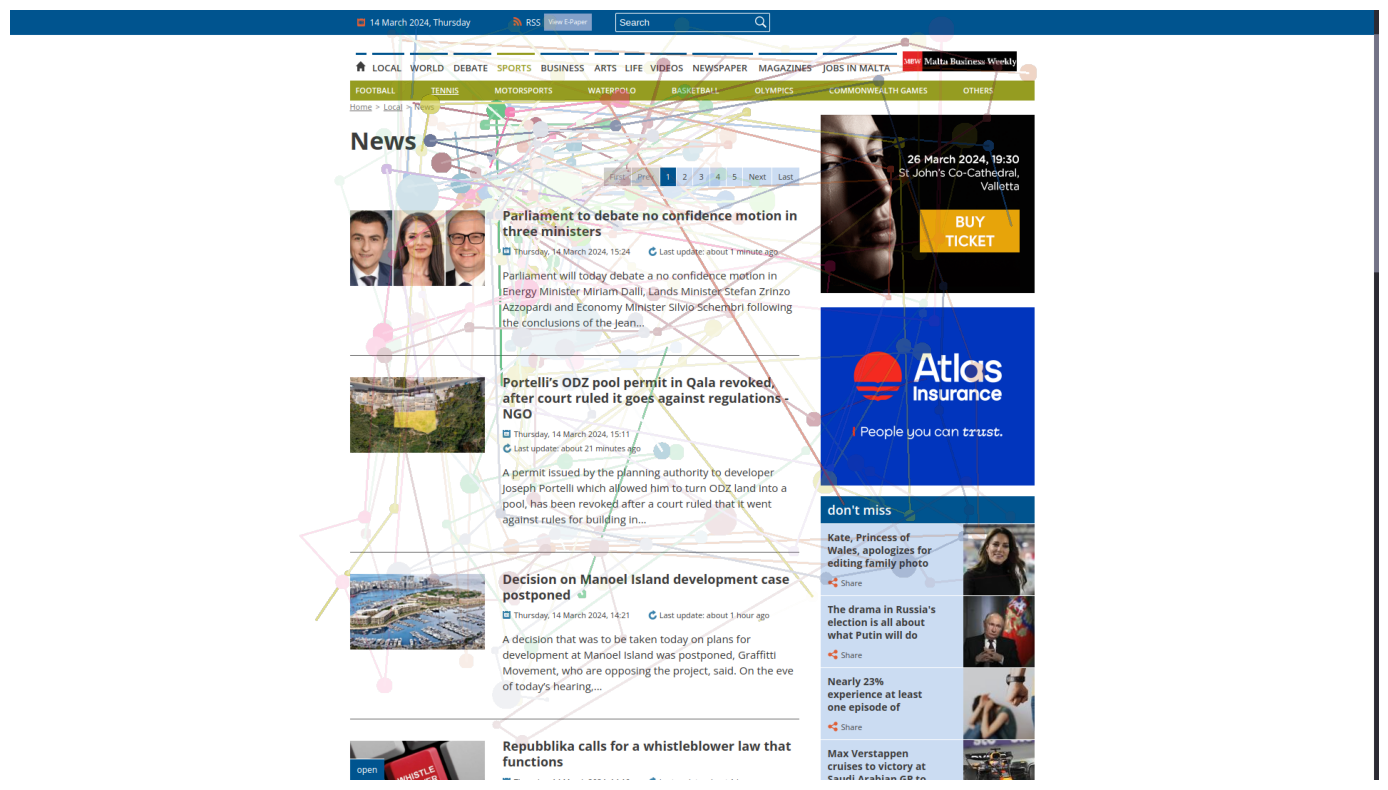

In [201]:
plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(imgs[img_paths[4]], cv2.COLOR_BGR2RGB))
heatmap_test = heatmaps[img_paths[4]]
heatmap_test = np.roll(heatmap_test, y_roll, axis=0)
heatmap_test = np.roll(heatmap_test, x_roll, axis=1)
# heatmap_test = cv2.GaussianBlur(heatmap_test, (251, 251), 50)

# Move all y points down by 20

plt.axis('off')
plt.imshow(heatmap_test.astype('uint8'), alpha=0.7)

In [51]:
# Initialize the heatmaps dictionary
heatmaps = {}

r = 5
xs = []
factor = 1920 / 1080
# Initialize heatmaps for each image
for img_path in img_paths:
    # heatmaps[img_path] = np.zeros((imgs[img_path].shape[0], imgs[img_path].shape[1]))
    heatmaps[img_path] = np.zeros((1080, 1920))

# Add circles from a_df with a progress bar
for i, row in tqdm(a_df.iterrows(), total=a_df.shape[0], desc='Processing a_df'):
    img_path = row['MEDIA_NAME']
    intensity = row['FPOGD']

    if img_path not in incl:
        continue

    if row['FPOGX'] < 0 or row['FPOGY'] < 0 or row['FPOGX'] > 1 or row['FPOGY'] > 1:
        continue

    # Check if landscape or portrait
    # if imgs[img_path].shape[0] > imgs[img_path].shape[1]: # Portrait
    #     # Image was displayed as 1080x1920 in the middle of 1920x1080, should be scaled to 1920x1080
    #     x = np.floor(row['FPOGX'] * imgs[img_path].shape[1]).astype(int)
    #     xs.append(x)
    #     y = np.floor(row['FPOGY'] * imgs[img_path].shape[0]).astype(int)

    # else: # Landscape
    #     x = np.floor(row['FPOGX'] * imgs[img_path].shape[1]).astype(int)
    #     y = np.floor(row['FPOGY'] * imgs[img_path].shape[0]).astype(int)

    
    x = np.floor(row['FPOGX'] * np.zeros((1080, 1920)).shape[1]).astype(int)
    y = np.floor(row['FPOGY'] * np.zeros((1080, 1920)).shape[0]).astype(int)

    add_circle_to_heatmap(heatmaps[img_path], x, y, r, intensity)
    # heatmaps[img_path][y, x] += 1

# Add circles from b_df with a progress bar
for i, row in tqdm(b_df.iterrows(), total=b_df.shape[0], desc='Processing b_df'):
    img_path = row['MEDIA_NAME']
    intensity = row['FPOGD']

    if img_path not in incl:
        continue

    if row['FPOGX'] < 0 or row['FPOGY'] < 0 or row['FPOGX'] > 1 or row['FPOGY'] > 1:
        continue

    # else: # Landscape
    #     x = np.floor(row['FPOGX'] * imgs[img_path].shape[1]).astype(int)
    #     y = np.floor(row['FPOGY'] * imgs[img_path].shape[0]).astype(int)

    
    x = np.floor(row['FPOGX'] * np.zeros((1080, 1920)).shape[1]).astype(int)
    y = np.floor(row['FPOGY'] * np.zeros((1080, 1920)).shape[0]).astype(int)
    
    add_circle_to_heatmap(heatmaps[img_path], x, y, r, intensity)
    # heatmaps[img_path][y, x] += 1

for img_path in img_paths:
    # Crop portait heatmaps, they are currently 1920x1080, must be 1080x1920 
    if imgs[img_path].shape[0] > imgs[img_path].shape[1]:
        heatmaps[img_path] = heatmaps[img_path][:, 420:1500]
        # Scale to 1080x1920
        heatmaps[img_path] = cv2.resize(heatmaps[img_path], (1920, 1920))
        heatmaps[img_path] = heatmaps[img_path][:, 420:1500]

# Save heatmaps to pickle
with open('heatmaps.pkl', 'wb') as f:
    pickle.dump(heatmaps, f)

Processing b_df: 100%|██████████| 73303/73303 [00:06<00:00, 11350.24it/s]


In [34]:
with open('heatmaps.pkl', 'rb') as f:
    heatmaps = pickle.load(f)

In [63]:
x_roll = -20
y_roll = 50

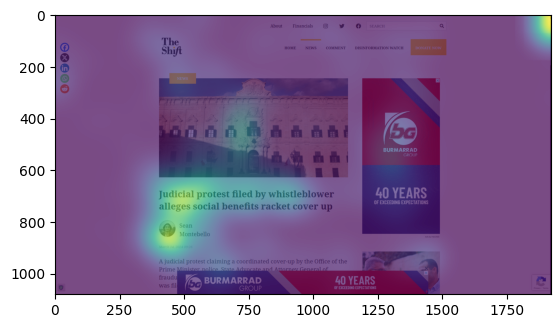

In [64]:
plt.imshow(cv2.cvtColor(imgs[img_paths[12]], cv2.COLOR_BGR2RGB))
heatmap_test = heatmaps[img_paths[12]]
heatmap_test = np.roll(heatmap_test, y_roll, axis=0)
heatmap_test = np.roll(heatmap_test, x_roll, axis=1)
heatmap_test = cv2.GaussianBlur(heatmap_test, (251, 251), 50)

# Move all y points down by 20

plt.imshow(heatmap_test, alpha=0.7)

Saved heatmap for THE_SHIFT_14_03_24_A.png
Saved heatmap for THE_SHIFT_14_03_24_B.png


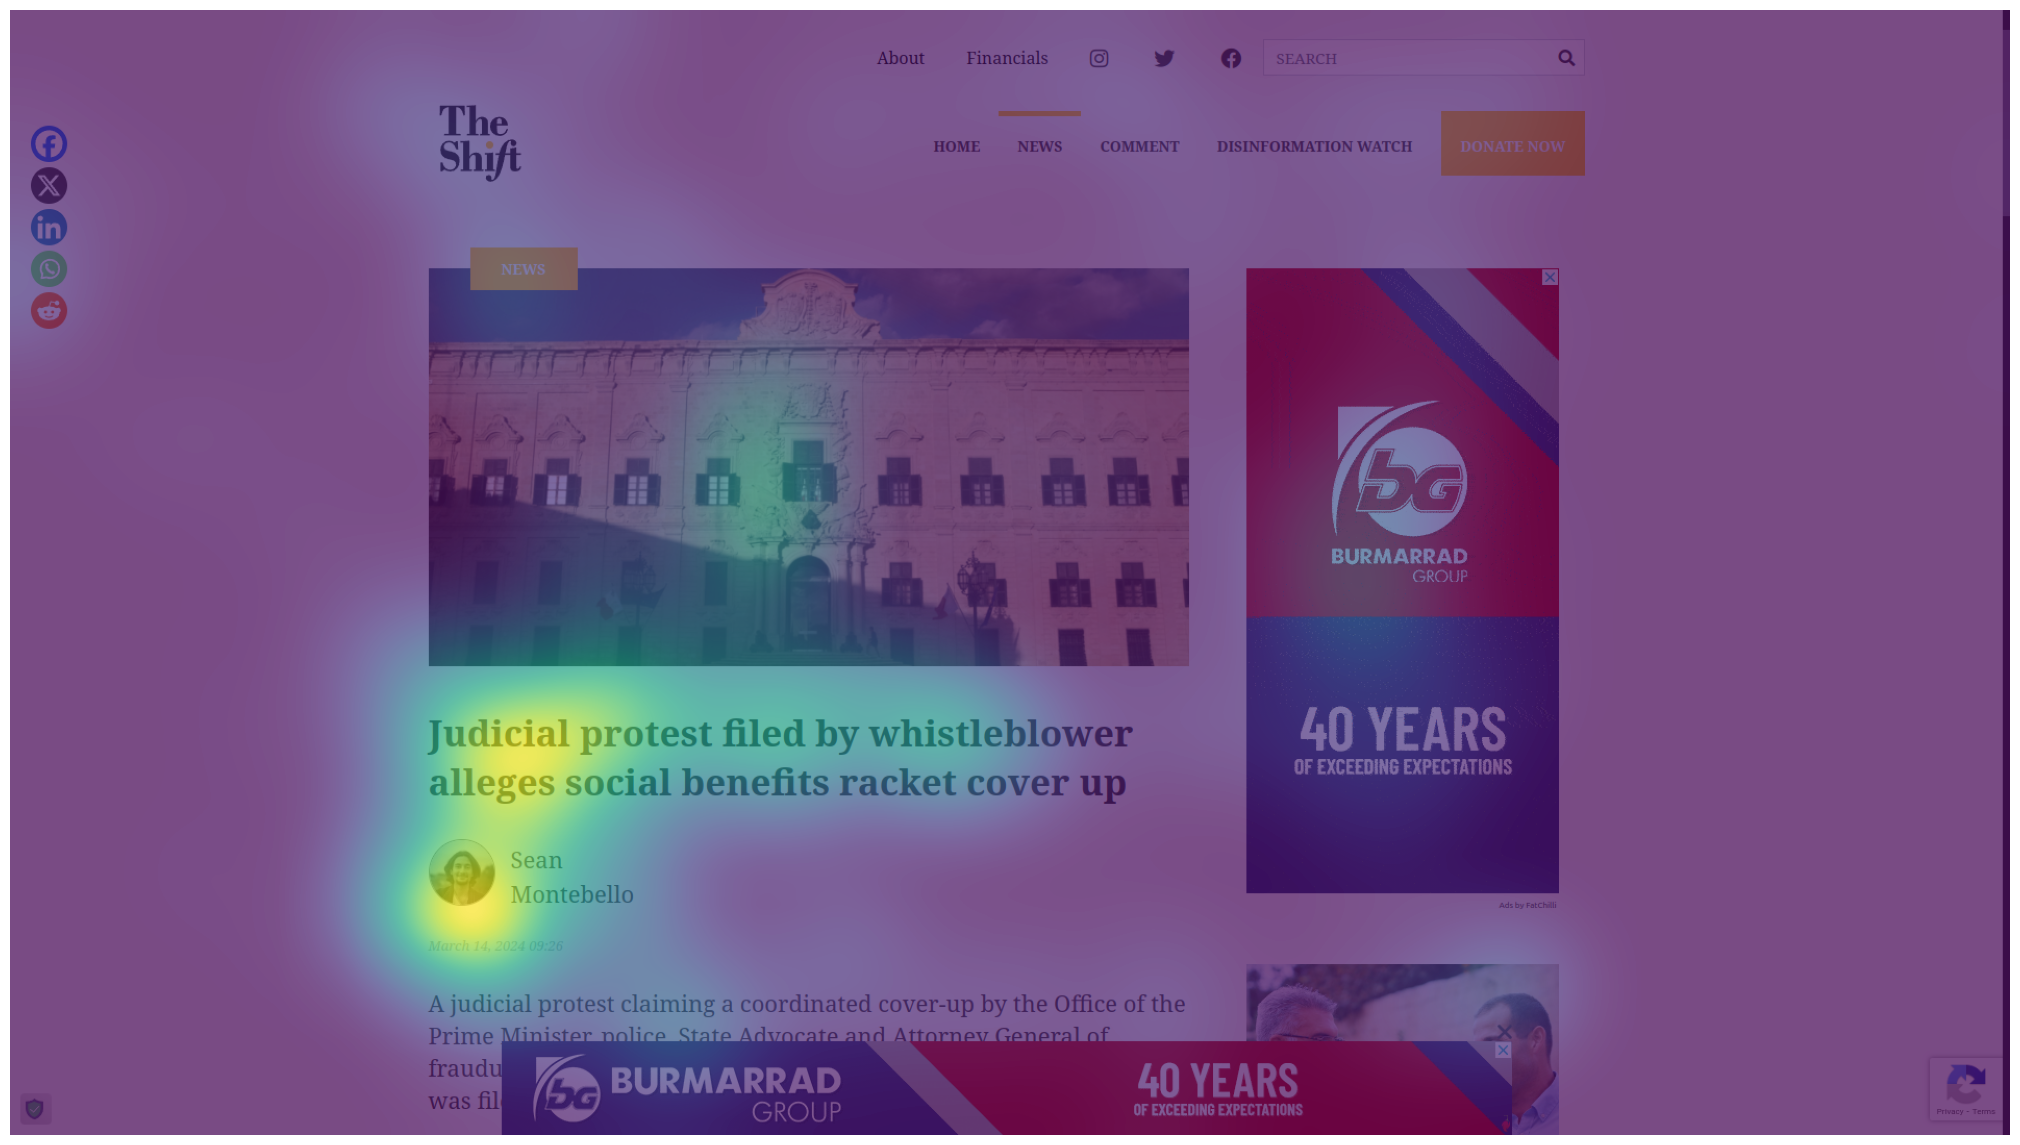

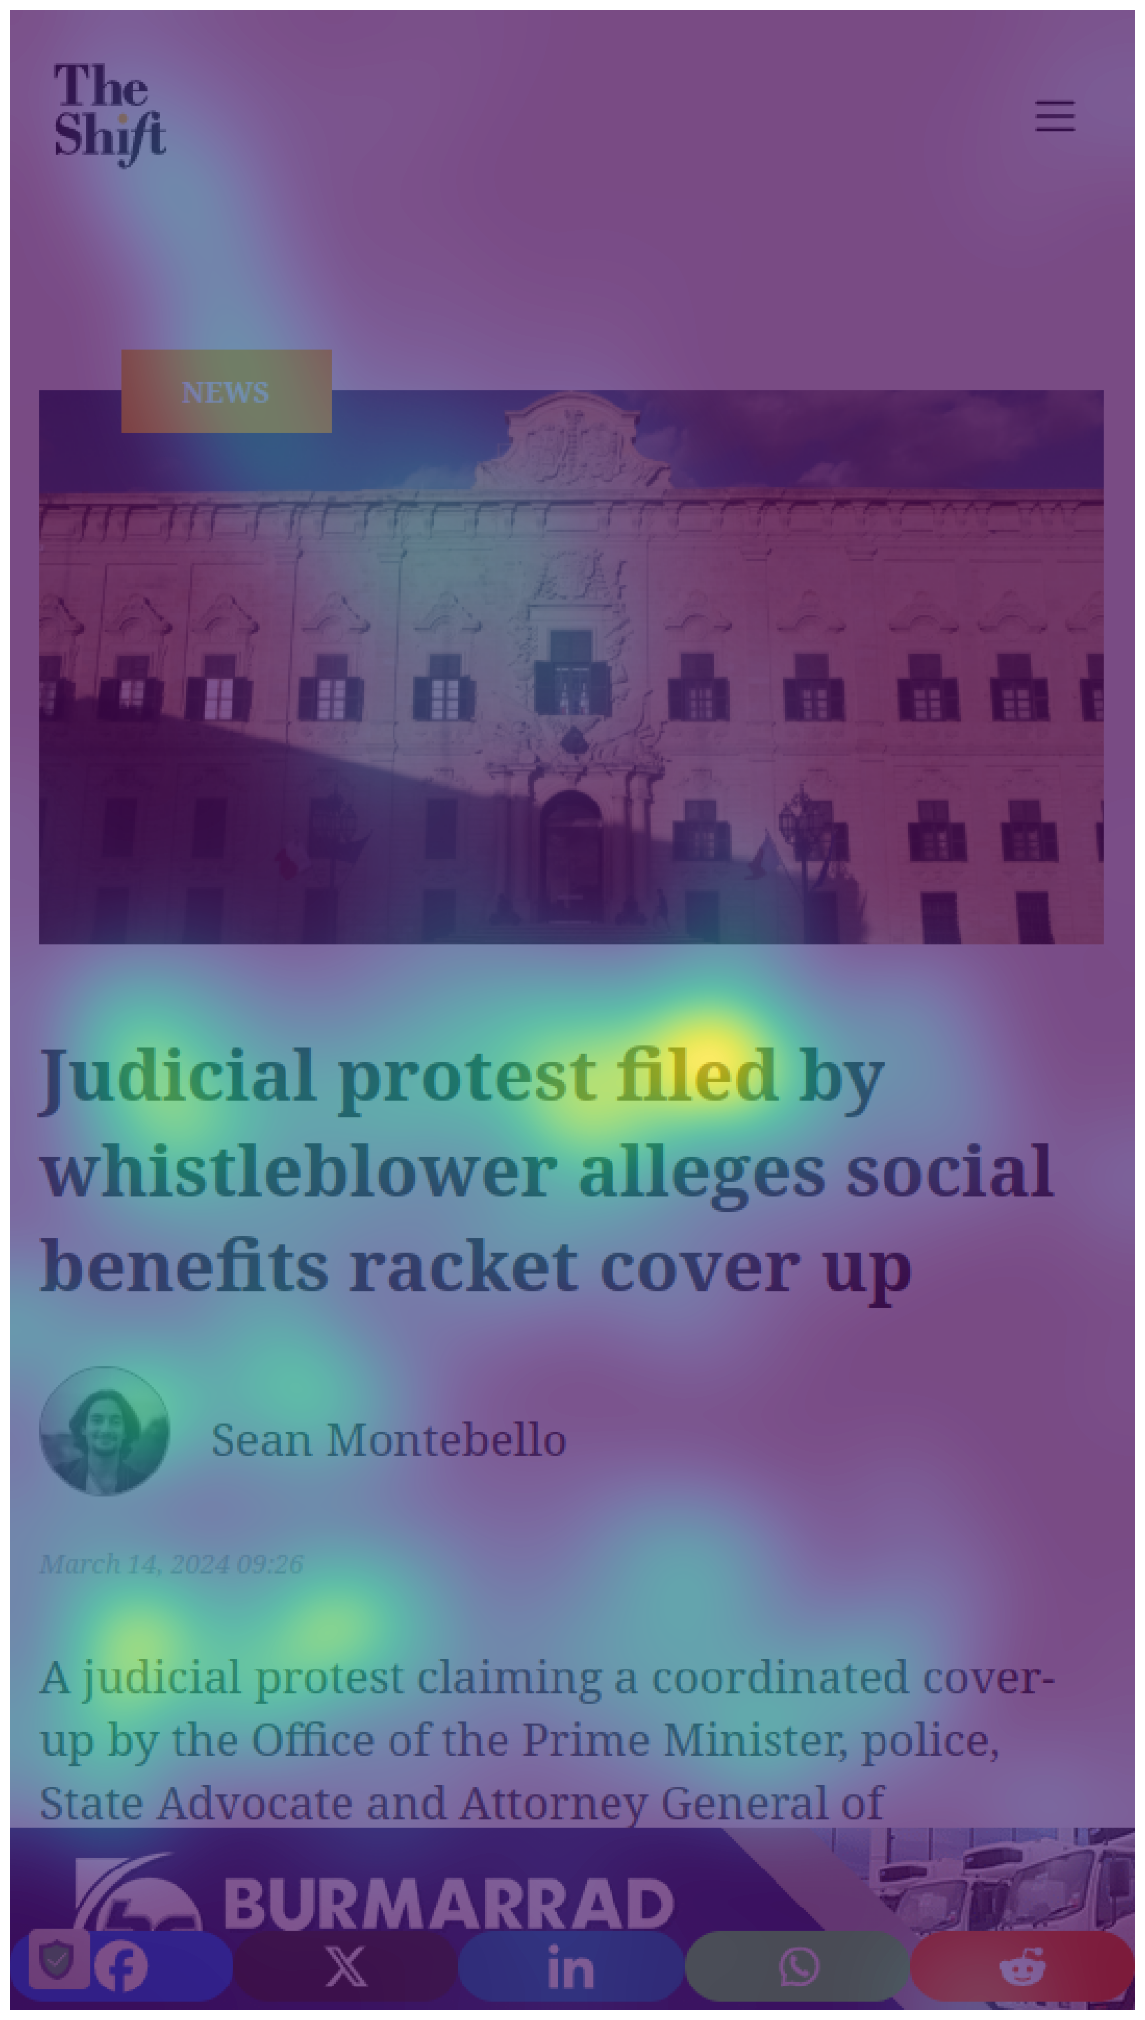

In [65]:
# Export all heatmaps to the folder ./heatmaps
for img_path in img_paths:
    if img_path not in incl:
        continue
    
    # if img_path != img_paths[10]:
    #     continue
    plt.figure(figsize=(20, 20))
    heatmap_test = heatmaps[img_path]
    # Remove any pixels from the top left corner (0:5, 0:5)
    heatmap_test[0:5, 0:5] = 0
    # heatmap_test = heatmaps[img_path] // 2
    heatmap_test = np.roll(heatmap_test, y_roll, axis=0)
    heatmap_test = np.roll(heatmap_test, x_roll, axis=1)
    heatmap_test = cv2.GaussianBlur(heatmap_test, (251, 251), 50)
    plt.imshow(cv2.cvtColor(imgs[img_path], cv2.COLOR_BGR2RGB))
    plt.imshow(heatmap_test, cmap='viridis', alpha=0.7)
    plt.axis('off')
    plt.tight_layout()

    plt.gca().set_position([0, 0, 1, 1])
    plt.savefig('new_eye/' + img_path, bbox_inches='tight', pad_inches=0)
    print('Saved heatmap for', img_path)

In [56]:
file_dict

{'DESKTOP_A.png': '../evaluation/Figures\\Custom (DESKTOP)\\DESKTOP_A_EYE_VIRIDIS.png',
 'DESKTOP_B.png': '../evaluation/Figures\\Custom (DESKTOP)\\DESKTOP_B_EYE_VIRIDIS.png',
 'MOBILE_A.png': '../evaluation/Figures\\Custom (MOBILE)\\MOBILE_A_EYE_VIRIDIS.png',
 'MOBILE_B.png': '../evaluation/Figures\\Custom (MOBILE)\\MOBILE_B_EYE_VIRIDIS.png',
 'ILLUM_14_03_24_A.png': '../evaluation/Figures\\Illum\\ILLUM_14_03_24_A_EYE_VIRIDIS.png',
 'ILLUM_14_03_24_B.png': '../evaluation/Figures\\Illum\\ILLUM_14_03_24_B_EYE_VIRIDIS.png',
 'MALTA_TODAY_14_03_24_A.png': '../evaluation/Figures\\Malta Today\\MALTA_TODAY_14_03_24_A_EYE_VIRIDIS.png',
 'MALTA_TODAY_14_03_24_B.png': '../evaluation/Figures\\Malta Today\\MALTA_TODAY_14_03_24_B_EYE_VIRIDIS.png',
 'INDEPENDENT_14_03_24_A.png': '../evaluation/Figures\\The Malta Independent\\INDEPENDENT_14_03_24_A_EYE_VIRIDIS.png',
 'INDEPENDENT_14_03_24_B.png': '../evaluation/Figures\\The Malta Independent\\INDEPENDENT_14_03_24_B_EYE_VIRIDIS.png',
 'THE_SHIFT_14_0

Saved heatmap for THE_SHIFT_14_03_24_A.png
Saved heatmap for THE_SHIFT_14_03_24_B.png


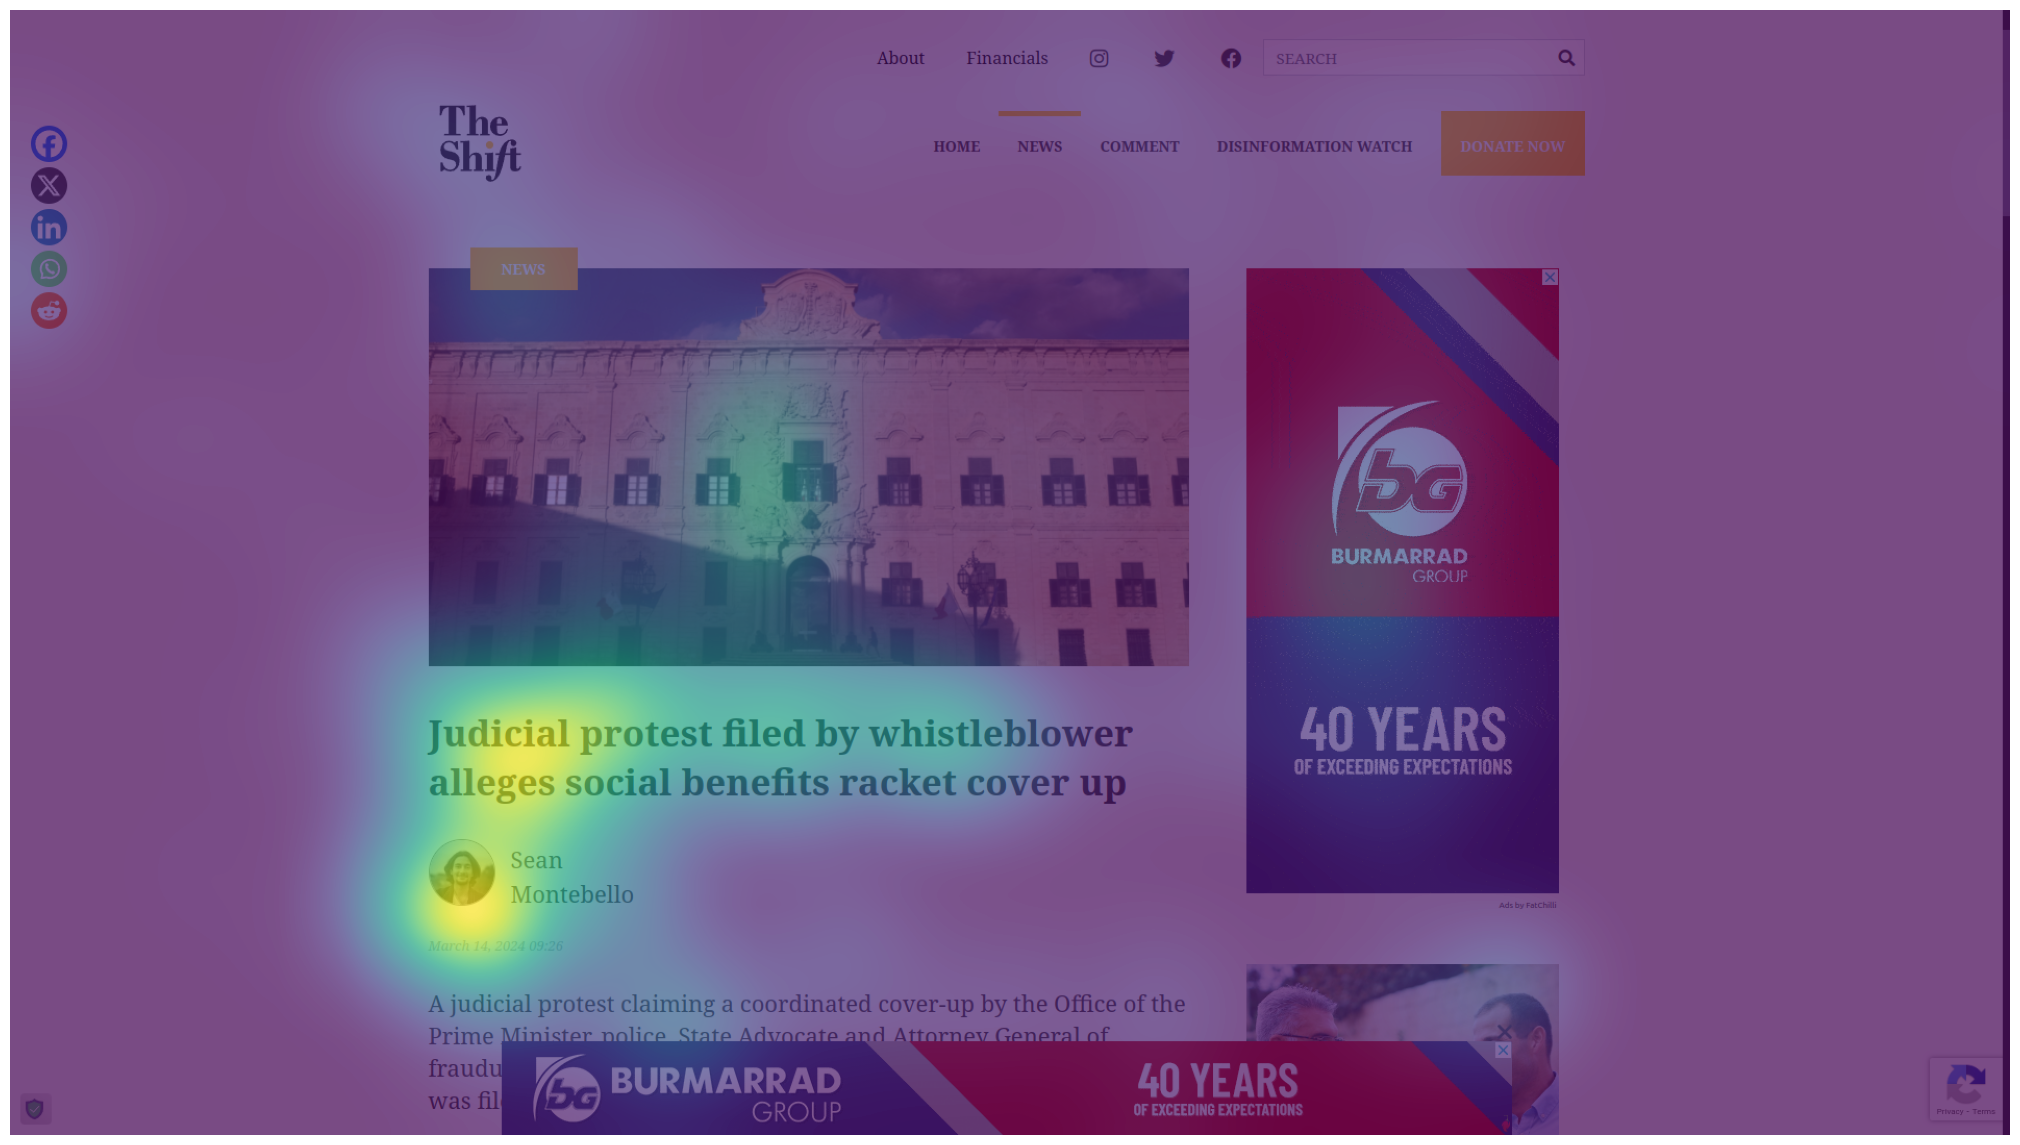

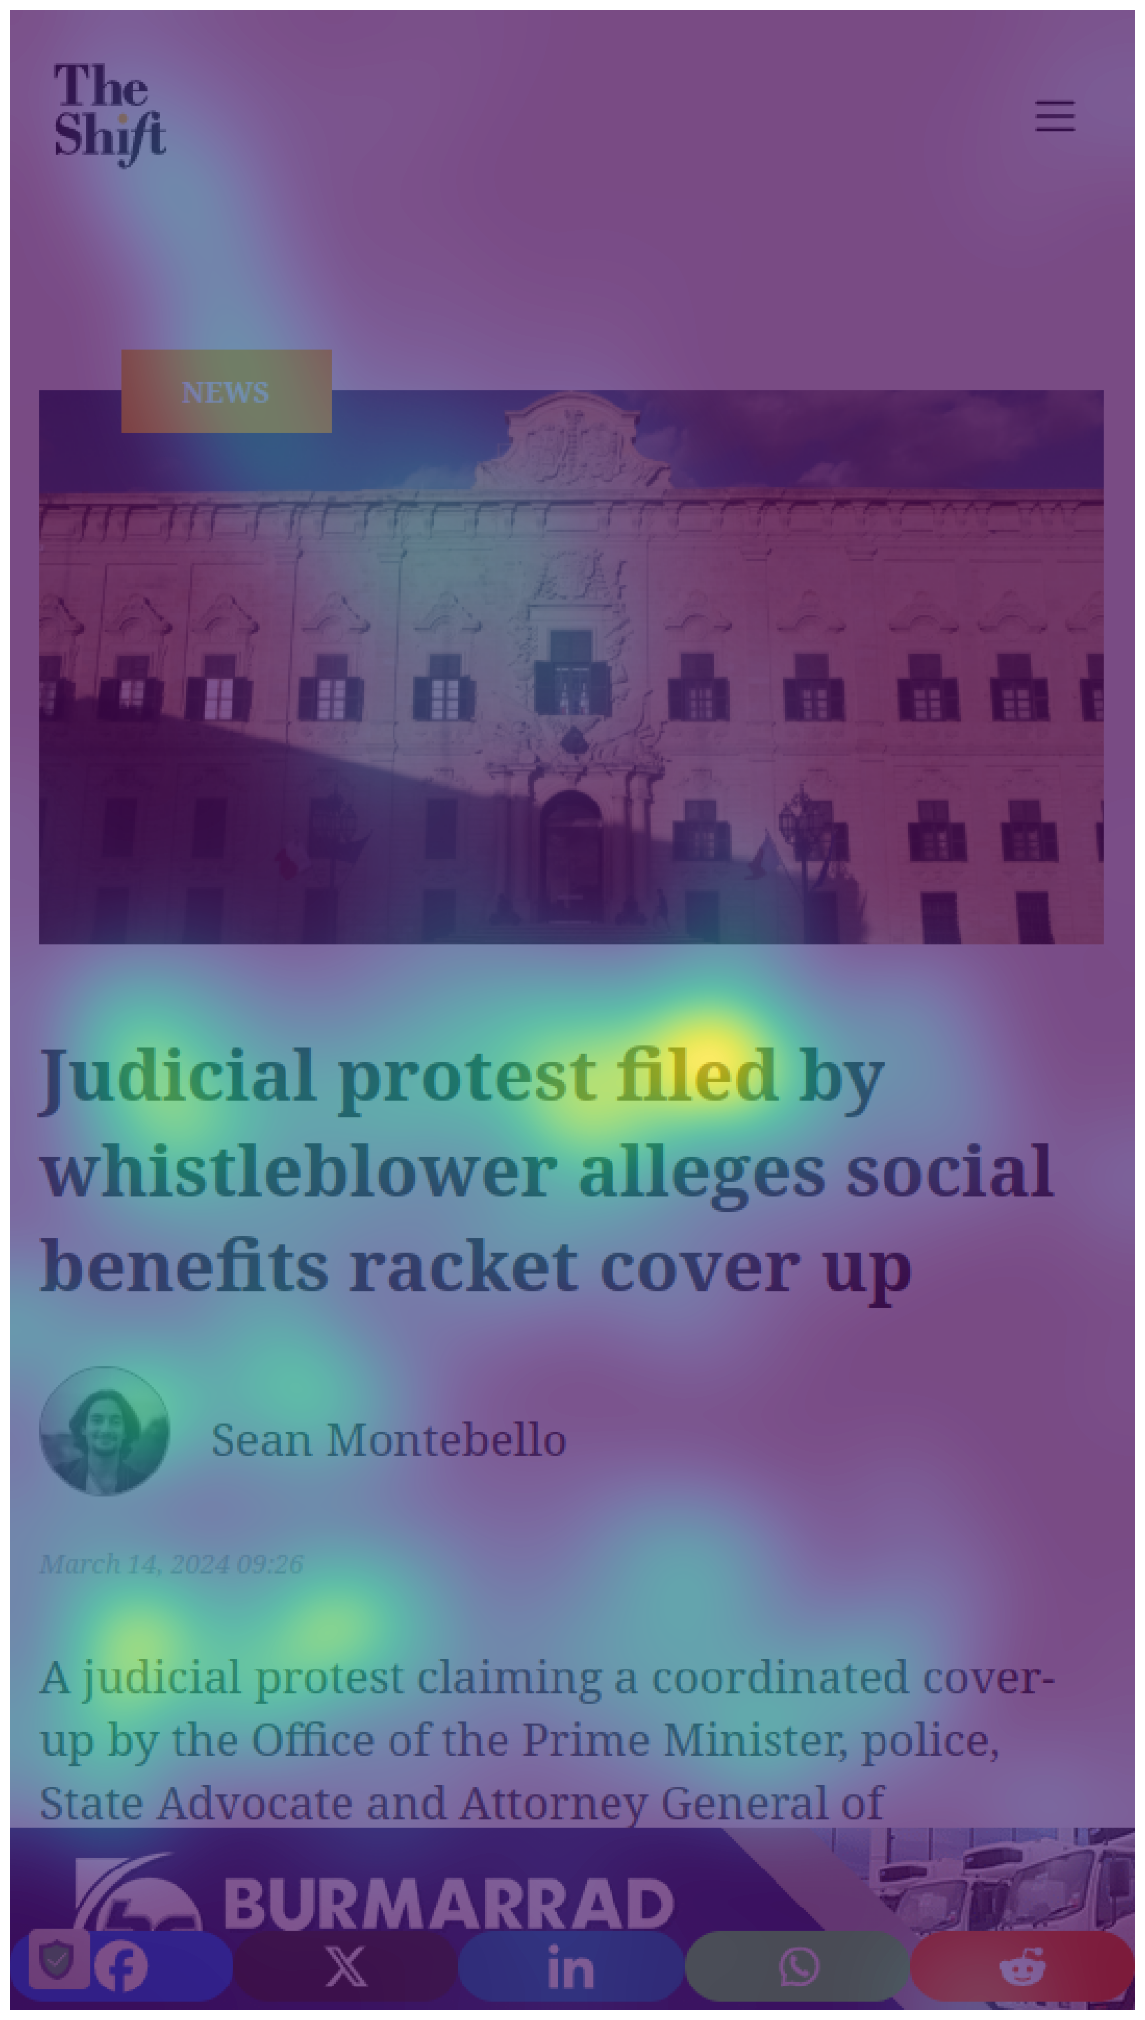

In [66]:
# List all files in ../evaluation/Figures, recursive
files = []

for r, d, f in os.walk('../evaluation/Figures'):
    for file in f:
        files.append(os.path.join(r, file))

# Find file names which contain the img_paths (just the file name)
files = [f for f in files if any(img_path in f for img_path in img_paths)]

# For each match, make an entry in a dictionary fromthe file name to the file path
file_dict = {}

for f in files:
    for img_path in img_paths:
        if img_path not in incl:
            continue
        if img_path in f:
            file_dict[img_path] = f

# Append "_EYE_VIRIDIS" to each value in file_dict
file_dict = {k: v.replace('.png', '_EYE_VIRIDIS.png') for k, v in file_dict.items()}

# Export all heatmaps to the corresponding path in file_dict
for img_path in img_paths:
    if img_path not in incl:
        continue
    
    try:
        plt.figure(figsize=(20, 20))
        heatmap_test = heatmaps[img_path]
        # Remove any pixels from the top left corner (0:5, 0:5)
        heatmap_test[0:5, 0:5] = 0
        # heatmap_test = heatmaps[img_path] // 2
        heatmap_test = np.roll(heatmap_test, y_roll, axis=0)
        heatmap_test = np.roll(heatmap_test, x_roll, axis=1)
        heatmap_test = cv2.GaussianBlur(heatmap_test, (251, 251), 50)
        plt.imshow(cv2.cvtColor(imgs[img_path], cv2.COLOR_BGR2RGB))
        plt.imshow(heatmap_test, cmap='viridis', alpha=0.7)
        plt.axis('off')
        plt.tight_layout()

        plt.gca().set_position([0, 0, 1, 1])
        plt.savefig(file_dict[img_path], bbox_inches='tight', pad_inches=0)
        print('Saved heatmap for', img_path)
    except:
        print('Failed to save heatmap for', img_path)

In [ ]:
file_dict